In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.optimize import root_scalar

In [153]:
# TEMPLATE CLASS
class ContinuousPokerTemplate:
    @staticmethod
    def value_size(game_params, x):
        raise NotImplementedError("value_size method must be implemented in subclasses")
    
    @staticmethod
    def bluff_size(game_params, x):
        raise NotImplementedError("bluff_size method must be implemented in subclasses")

    @staticmethod
    def call_threshold(game_params, s):
        raise NotImplementedError("call_threshold method must be implemented in subclasses")
    
    @staticmethod
    def bluff_threshold(game_params):
        raise NotImplementedError("bluff_threshold method must be implemented in subclasses")
    
    @staticmethod
    def value_threshold(game_params):
        raise NotImplementedError("value_threshold method must be implemented in subclasses")

    @classmethod
    def payoff_outcome(cls, game_params, x, y):
        if x < cls.bluff_threshold(game_params): # bluff
            s = cls.bluff_size(game_params, x)
            if y < cls.call_threshold(game_params, s):
                return 0.5, "Bluff_Fold"
            else:
                return -s - 0.5, "Bluff_Called"
        elif x > cls.value_threshold(game_params): # value bet
            s = cls.value_size(game_params, x)
            if y < cls.call_threshold(game_params, s):
                return 0.5, "Value_Fold"
            elif y > x:
                return -s - 0.5, "Value_Loses"
            else:
                return s + 0.5, "Value_Wins"
        else: 
            if x > y:
                return 0.5, "Check_Wins" 
            else:
                return -0.5, "Check_Loses"
            
    @classmethod
    def expected_payoff(cls, game_params, grid_size=1001):
        # numerically integrate the payoff(x, y) function over the grid [0,1] x [0,1]
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        payoff_data = np.empty((grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, _ = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                except:
                    payoff_data[i, j] = np.nan
        average_payoff = np.nanmean(payoff_data)
        return average_payoff
                
    @classmethod
    def generate_strategy_plot(cls, game_params, s_lim=None, grid_size=1001, save_path=None, title="Strategy Profile"):
        # find bluff and value sizes for each x
        X = np.linspace(0, 1, grid_size)
        bet_sizes = np.empty(grid_size)
        call_thresholds = np.empty(grid_size)
        for i, x in enumerate(X):
            if x < cls.bluff_threshold(game_params):
                s = cls.bluff_size(game_params, x)
            elif x > cls.value_threshold(game_params):
                s = cls.value_size(game_params, x)
            else:
                s = 0
            bet_sizes[i] = s

        # Add artificial points for perfect vertical lines
        adjusted_X = []
        adjusted_bet_sizes = []
        for i in range(len(bet_sizes) - 1):
            adjusted_X.append(X[i])
            adjusted_bet_sizes.append(bet_sizes[i])
            if bet_sizes[i] != 0 and bet_sizes[i + 1] == 0:
                adjusted_X.append(X[i])
                adjusted_bet_sizes.append(0)
            elif bet_sizes[i] == 0 and bet_sizes[i + 1] != 0:
                adjusted_X.append(X[i + 1])
                adjusted_bet_sizes.append(0)
        adjusted_X.append(X[-1])
        adjusted_bet_sizes.append(bet_sizes[-1])

        adjusted_X = np.array(adjusted_X)
        adjusted_bet_sizes = np.array(adjusted_bet_sizes)

        if s_lim is None:
            s_lim = np.max(adjusted_bet_sizes) * 1.1

        # find call thresholds for each s
        s_min = np.min(adjusted_bet_sizes[adjusted_bet_sizes > 0])
        s_max = np.max(adjusted_bet_sizes[adjusted_bet_sizes != np.inf])
        S = np.linspace(s_min, s_max, grid_size)
        for i, s in enumerate(S):
            call_thresholds[i] = cls.call_threshold(game_params, s)

        # plot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot bet sizes as a function of x
        ax.plot(adjusted_X, adjusted_bet_sizes, label="Bet Function", color="red", linewidth=2)

        # Plot call thresholds as a function of s
        if s_min == s_max:
            # point instead of line
            ax.plot(call_thresholds, S, label="Call Threshold", color="blue", marker="o", markersize=5)
            ax.plot([call_thresholds[0], 1], [S[0], S[0]], color="blue", linestyle="--", alpha=0.3, linewidth=2, label="Call Region") 
        else:
            ax.plot(call_thresholds, S, label="Call Threshold", color="darkblue", linestyle="--", linewidth=2)
            ax.fill_betweenx(S, call_thresholds, np.ones_like(S), color="blue", alpha=0.3, label="Call Region")

        # ---- Labels, Legend, and Title ----
        ax.set_xlabel("Hand Strength", fontsize=12)
        ax.set_ylabel("Bet Size", fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True)

        # ---- Save or Show ----
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()


    @classmethod
    def generate_payoff_plot(cls, game_params, grid_size=1001, save_path=None, title="Payoffs by Hand Strength"):
        # ---- Parameters ----
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        X, Y = np.meshgrid(xs, ys, indexing='ij')
        color_cap = 2

        # ---- Compute payoff grid ----
        payoff_data = np.empty((grid_size, grid_size))
        outcome_type = np.empty((grid_size, grid_size), dtype=object)
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, outcome = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                    outcome_type[i, j] = outcome
                except:
                    payoff_data[i, j] = np.nan
        payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

        region_labels = [
            "Bluff_Called", "Bluff_Fold",
            "Value_Wins", "Value_Loses", "Value_Fold",
            "Check_Wins", "Check_Loses"
        ]

        # ---- Plot heatmap with region contours and labels ----
        fig, ax = plt.subplots(figsize=(7, 7))
        c = ax.imshow(
            payoff_clipped.T,
            extent=[0, 1, 0, 1],
            origin='lower',
            cmap='coolwarm',
            norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
        )
        cbar = fig.colorbar(c, ax=ax, shrink=0.9)
        cbar.set_label("Bettor Payoff", fontsize=12)
        cbar.set_ticks([-color_cap, 0, color_cap])
        cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

        for label in region_labels:
            mask = outcome_type == label
            if np.any(mask):
                ax.contour(
                    X, Y, mask.astype(float),
                    levels=[0.5],
                    colors='white',
                    linewidths=1.5
                )
                region_center = np.argwhere(mask)
                if len(region_center) > 0:
                    center_x, center_y = region_center.mean(axis=0)
                    ax.text(
                        xs[int(center_x)], ys[int(center_y)],
                        label.replace("_", " "),
                        color="white",
                        fontsize=10,
                        ha="center",
                        va="center",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
                    )

        ax.set_xlabel("x (bettor hand strength)")
        ax.set_ylabel("y (caller hand strength)")
        ax.set_title(title)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300)
        plt.show()

In [158]:
# FIXED BET CONTINUOUS POKER 

class CP(ContinuousPokerTemplate):
    # ---- Threshold functions ----
       
    def bluff_threshold(game_params):
        B = game_params['B']
        return 2 * B / ((1 + 2 * B) * (4 + 2 * B))

    def value_threshold(game_params):
        B = game_params['B']
        return (2 + 8 * B + 4 * B**2) / ((1 + 2 * B) * (4 + 2 * B))

    def call_threshold(game_params, s):
        return (2 * s * (3 + 2 * s)) / ((1 + 2 * s) * (4 + 2 * s))

    def bluff_size(game_params, x):
        return game_params['B']

    def value_size(game_params, x):
        return game_params['B']

In [154]:
# NO LIMIT CONTINUOUS POKER
class NLCP(ContinuousPokerTemplate):
    def bluff_threshold(game_params):
        return 1 / 7

    def value_threshold(game_params):
        return 4 / 7

    def call_threshold(game_params, s):
        return 1 - 6 / (7 * (1 + s))

    def bluff_size(game_params, x):
        return (1 / (7 * x)**(1/3)) - 1

    def value_size(game_params, x):
        return np.sqrt(3 / (7 * (1 - x))) - 1

In [134]:
# L, U LIMIT CONTINUOUS POKER

class LCP_utils:
    _cache = {}
    _last_game_params = None

    @staticmethod
    def clear_cache():
        LCP_utils._cache.clear()
        LCP_utils._last_game_params = None

    @staticmethod
    def check_and_clear_cache(game_params):
        if LCP_utils._last_game_params != game_params:
            LCP_utils.clear_cache()
            LCP_utils._last_game_params = game_params

    @staticmethod
    def compute_A0(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A0' not in LCP_utils._cache:
            LCP_utils._cache['A0'] = U**2 + 3 * U + 3
        return LCP_utils._cache['A0']

    @staticmethod
    def compute_A1(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A1' not in LCP_utils._cache:
            LCP_utils._cache['A1'] = 7 * U**3 + 21 * U**2 + 21 * U + 6
        return LCP_utils._cache['A1']

    @staticmethod
    def compute_A2(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A2' not in LCP_utils._cache:
            LCP_utils._cache['A2'] = 6 * U**3 + 18 * U**2 + 18 * U + 5
        return LCP_utils._cache['A2']

    @staticmethod
    def compute_A3(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A3' not in LCP_utils._cache:
            LCP_utils._cache['A3'] = 7 * U**3 + 21 * U**2 + 18 * U + 3
        return LCP_utils._cache['A3']

    @staticmethod
    def compute_A4(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A4' not in LCP_utils._cache:
            A1 = LCP_utils.compute_A1(game_params)
            A2 = LCP_utils.compute_A2(game_params)
            LCP_utils._cache['A4'] = 3 * A1 * L**2 + 3 * A1 * L + A1 + A2 * L**3
        return LCP_utils._cache['A4']

    @staticmethod
    def compute_A5(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A5' not in LCP_utils._cache:
            A0 = LCP_utils.compute_A0(game_params)
            LCP_utils._cache['A5'] = 3 * A0 * L**2 * U + 3 * A0 * L * U + A0 * U - L**3
        return LCP_utils._cache['A5']

    @staticmethod
    def compute_x0(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x0' not in LCP_utils._cache:
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x0'] = (3 * (L + 1)**3 * U) / A4
        return LCP_utils._cache['x0']

    @staticmethod
    def compute_x1(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x1' not in LCP_utils._cache:
            A0 = LCP_utils.compute_A0(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x1'] = (3 * A0 * L * U + A0 * U - L**3 - 3 * L**2) / A4
        return LCP_utils._cache['x1']

    @staticmethod
    def compute_x2(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x2' not in LCP_utils._cache:
            A5 = LCP_utils.compute_A5(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x2'] = A5 / A4
        return LCP_utils._cache['x2']

    @staticmethod
    def compute_x3(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x3' not in LCP_utils._cache:
            A2 = LCP_utils.compute_A2(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x3'] = (A2 * L**3 + 3 * A2 * L**2 + 3 * L * (5 * U**3 + 15 * U**2 + 15 * U + 4) +
                                        4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
        return LCP_utils._cache['x3']

    @staticmethod
    def compute_x4(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x4' not in LCP_utils._cache:
            A1 = LCP_utils.compute_A1(game_params)
            A2 = LCP_utils.compute_A2(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x4'] = (3 * A1 * L**2 + A2 * L**3 + 3 * A2 * L + 4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
        return LCP_utils._cache['x4']

    @staticmethod
    def compute_x5(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x5' not in LCP_utils._cache:
            A3 = LCP_utils.compute_A3(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x5'] = (3 * A3 * L**2 + 3 * A3 * L + A3 + L**3 * (6 * U**3 + 18 * U**2 + 15 * U + 2)) / A4
        return LCP_utils._cache['x5']

    @staticmethod
    def compute_b0(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'b0' not in LCP_utils._cache:
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['b0'] = -(L + 1)**3 / A4
        return LCP_utils._cache['b0']
    
    @staticmethod
    def v_of_s(s, x2):
        return (x2 + 2*s**2 + 4*s + 1)/(2*(1 + s)**2)
    
    @staticmethod
    def b_of_s(s, b0, x2):
        return b0 - ((1 + 3*s)*(x2 - 1)) / (6*(1 + s)**3)



class LCP(ContinuousPokerTemplate):
    @staticmethod
    def inverse_b(x, b0, x2, bracket=(1e-6, 100)):
        # Solve b(s) = x for s
        f = lambda s: LCP_utils.b_of_s(s, b0, x2) - x
        sol = root_scalar(f, bracket=bracket, method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise ValueError("Root finding did not converge")

    @staticmethod
    def inverse_v(x, x2, bracket=(1e-6, 100)):
        # Solve v(s) = x for s
        f = lambda s: LCP_utils.v_of_s(s, x2) - x
        sol = root_scalar(f, bracket=bracket, method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise ValueError("Root finding did not converge")

    def call_threshold(game_params, s):
        x2 = LCP_utils.compute_x2(game_params)
        return (x2+s)/(1+s)
    
    def bluff_threshold(game_params):
        return LCP_utils.compute_x2(game_params)
    
    def value_threshold(game_params):
        return LCP_utils.compute_x3(game_params)
    
    def bluff_size(game_params, x):
        L = game_params['L']
        U = game_params['U']
        x0 = LCP_utils.compute_x0(game_params)
        x1 = LCP_utils.compute_x1(game_params)
        x2 = LCP_utils.compute_x2(game_params)
        b0 = LCP_utils.compute_b0(game_params)
        if x < x0:
            return U
        elif x < x1:
            return LCP.inverse_b(x, b0, x2)
        else:
            return L
        
    def value_size(game_params, x):
        L = game_params['L']
        U = game_params['U']
        x2 = LCP_utils.compute_x2(game_params)
        x4 = LCP_utils.compute_x4(game_params)
        x5 = LCP_utils.compute_x5(game_params)
        if x < x4:
            return L
        elif x < x5:
            return LCP.inverse_v(x, x2)
        else:
            return U

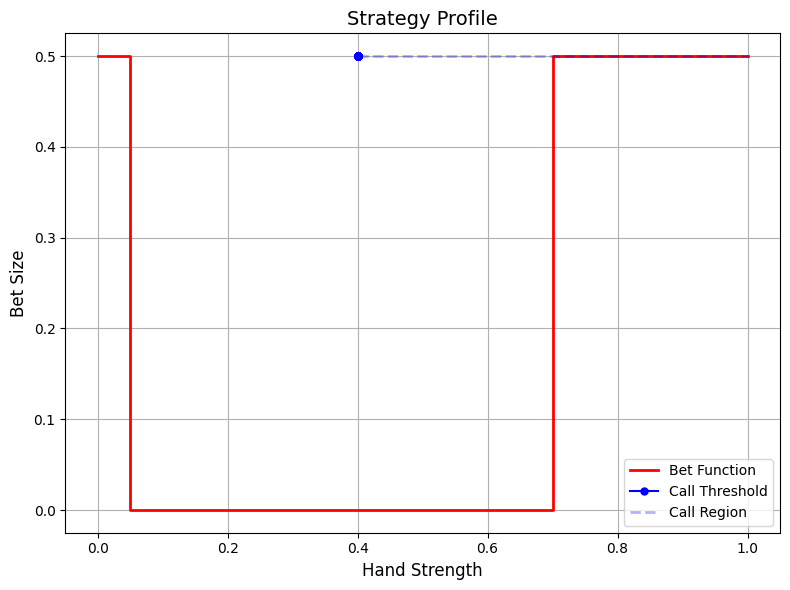

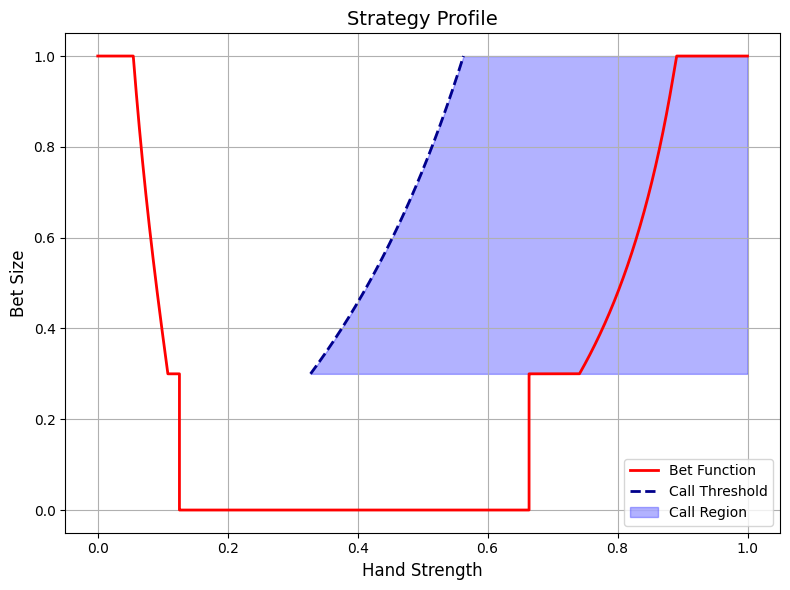

/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_6334/3504013127.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (7 * x)**(1/3)) - 1
/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_6334/3504013127.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(3 / (7 * (1 - x))) - 1


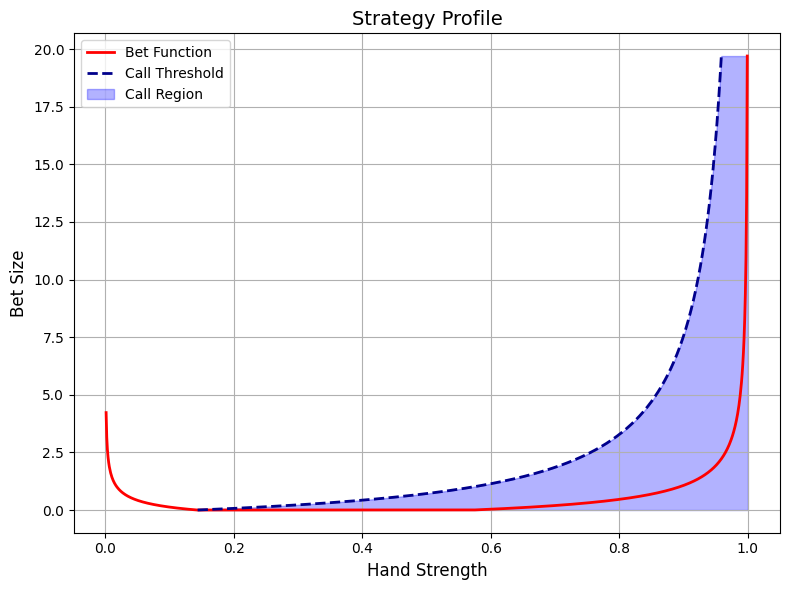

In [159]:
CP.generate_strategy_plot(game_params={'B': 0.5}, grid_size=21)
LCP.generate_strategy_plot(game_params={'L': 0.3, "U":1}, grid_size=10001)
NLCP.generate_strategy_plot({})
# LCP.value_size(game_params={'L': 0.5, "U":2}, x=0.65)
# LCP.inverse_v(x, x2)

In [ ]:
from tqdm.notebook import tqdm

# EXPECTED PAYOFF OVER L, U GRID
cap = 10
grid_size = 101
expected_payoff_grid_size = 101

# Create a grid of L and U values on a logarithmic scale
Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
L_grid, U_grid = np.meshgrid(Ls, Us)

# Initialize an array to store expected payoffs
payoff_grid = np.full_like(L_grid, np.nan, dtype=np.float64)

# Compute expected payoff for each pair (L, U) where L < U
for i in tqdm(range(L_grid.shape[0]), desc="Rows"):
    for j in range(L_grid.shape[1]):
        L = L_grid[i, j]
        U = U_grid[i, j]
        if L <= U:
            params = {"L": L, "U": U}
            LCP_utils.clear_cache()
            avg_payoff = LCP.expected_payoff(params, grid_size=expected_payoff_grid_size)
            payoff_grid[i, j] = avg_payoff


Rows:   0%|          | 0/101 [00:00<?, ?it/s]

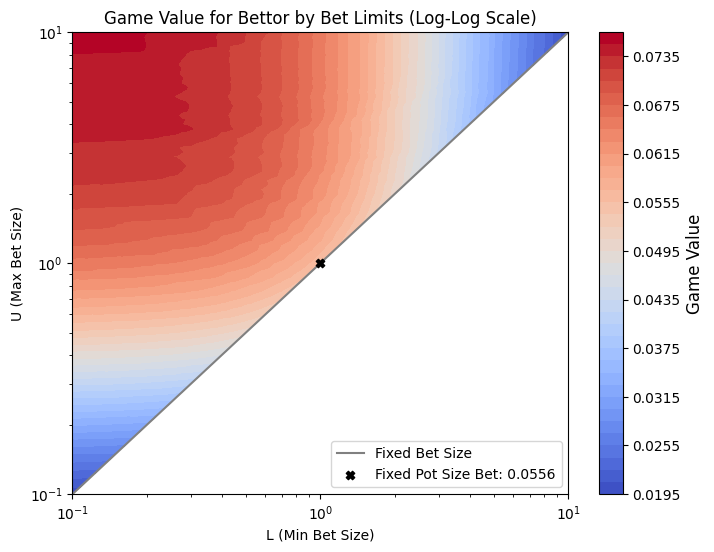

In [37]:
# Plot the heatmap on a log-log scale
plt.figure(figsize=(8, 6))
contour = plt.contourf(Ls, Us, payoff_grid, levels=50, cmap="coolwarm", vmax=np.nanmax(payoff_grid))

# Add a diagonal line from (0, 0) to (cap, cap)
plt.plot([1/cap, cap], [1/cap, cap], color="grey", linestyle="-", label="Fixed Bet Size")

# Add a point at (1,1) labeled with the value there, ensuring it is on the line
value_at_point = payoff_grid[np.argmin(np.abs(Ls - 1)), np.argmin(np.abs(Us - 1))]
plt.scatter(1, 1, marker="X", color="black", label=f"Fixed Pot Size Bet: {value_at_point:.4f}", zorder=5)
plt.legend(loc="lower right")  # Move the legend to the bottom right

# Add a color bar with the same colormap
cbar = plt.colorbar(contour)
cbar.set_label("Game Value", fontsize=12)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("L (Min Bet Size)")
plt.ylabel("U (Max Bet Size)")
plt.title("Game Value for Bettor by Bet Limits (Log-Log Scale)")
plt.show()
